<head> 
<style>
    h1 {text-align: center;}
</style>
</head>

<h1 style='font-size:40px'> CMSE 381 Honors Option </h1>
<h1>Collin Dobson</h1>
<h1>Dated: Nov 19, 2024</h1>

<h2 style='font-size:40px'> Table Of Contents </h2>

1. [Abstract](#abstract)

1. [Introduction](#intro)

    2.1 [Imports](#imports)
    
1. [Particle ID](#ParticleID)

    3.1 [Read In Data](#read1)

    3.2 [Data Cleaning](#clean1)

    3.3 [Predictor and Response](#pred_resp1)

    3.4 [First Look](#first_look1)

    3.5 [Visible Trends](#trends1)

    3.6 [Out of The Box PErformance](#oobp)

    3.7 [Can We Improve The Models?](#particle_improv1)

    3.8 [Can We Go Further?](#particle_improv2)

    3.9 [Final Classification Results](#particle_results)

1. [Binding Energy](#BindingE)

    4.1 [Read In Data](#read2)

    4.2 [Data Cleaning](#clean2)

    4.3 [First Look](#First_Look2)

    4.4 [Visible Trends](#trends2)

    4.5 [LASSO](#lasso)

    4.6 [Results for LASSO](#lasso_results)

    4.7 [Polynomial Regression](#poly)

    4.8 [Polynomial Regression Results](#poly_results)

    4.9 [Neural Network Regressor](#nn)

    4.10 [Neural Network Regression Results](#nn_results)

    4.11 [Final Regression Results](#regression_results)

1. [Discussion](#discussion)

    5.1 [Classification Discussion](#class_disc)

    5.2 [Regression Discussion](#reg_disc)

1. [References](#references)

<h2 style='font-size:40px'> Abstract </h2> <a id="abstract"></a>

&emsp;Two very important topics in the field of Nuclear Physics are binding energy and particle identification. And it is of great importance to the future of the field that both are studied in great detail. In this paper I attempted to create a machine learning model to predict the binding energy of nuclei based only on the subatomic particles that make them up and to make a classification model that takes the readout from a detector and predicts what kind of particle was observed. For the classification model I used a random forest classifier and a neural network classifier. After parameter tuning, both models showed great accuracy and potential for use in real applications. Both having an accuracy rate determined with KFold cross-validation of around 94%. For the regression model I applied LASSO, Polynomial Regression, and a Neural network regressor. The lowest KFold cross-validated MSE was 505,000, which was the polynomial regression. These results were very disappointing, and clearly demonstrated that a pure machine learning approach was not up to the task at hand, and a model that included theory was needed to improve the accuracy. 

<h2 style='font-size:40px'> Introduction </h2> <a id="intro"></a>

<img src="NuclearReaction.png" alt="Nuclear Reaction" width="400" style="display: block; margin: auto;"/>
<h1 style='font-size:12px'> NuclearReaction. (n.d.). In Wikimedia Commons </h1>

&emsp;The nucleus of atoms are made up of positively charged protons and neutrally charged neutrons, with negatively charged electrons somewhere outside of the nucleus "orbiting it". Much like in chemical bonds, the neutrons and protons in the nucleus are held together by some attractive force. This is called the strong nuclear force. Binding energy, or more accurately Nuclear Binding energy is the energy required to break apart a nucleus into its constituent parts, or in other words, overcome the pull of the strong nuclear force holding everything together. Binding energy is important because it governs what happens when you break a nucleus apart. When you break apart a nucleus it is much more likely that the resulting nuclei will be more stable, that is have a higher binding energy than the original nucleus. When these new nuclei form, assuming that they are more stable, they will release energy equal to the strength of the nuclear bond. As such is is of critical importance that the binding energies for any and all elements and their subsequent isotopes are known. So we will be working with a table of information about the different nuclei and attempting to find a model that can take those substituent parts and estimate the binding energy.

&emsp;On the other hand, particle identification is done in many different ways because different particles have different properties that can be drastically different, and because different detectors are more suited for different tasks. For neutral particles like neutrons or neutrinos detection is only possible through use of scintillators, which are materials that produce light when exposed to high energy particles. Usually these photons then hit a Photomultiplier Tube (PMT) that reconstructs the position of the interaction. For charged particles like protons or electrons they can just be measured by finding their velocity and momentum. This may be done by having two detectors separated by some distance that pick up particles excited by the particles of interest, and taking the timing difference. Then allowing the particle to collide with a calorimeter which outputs the momentum. Another method of particle identification may be done using what is called a time projection chamber. In a time projection chamber, high energy charged particles enter  through a port in one side travel through a medium, usually a high pressure gas, depart some energy to the gas as it passes through. As it deposits energy to the gas, electrons are kicked off of their host atoms float to the end of the chamber where they get picked up up electrodes. From these electrons, the path the particle traveled can be reconstructed. Then the properties of the particle can be determined by fitting known differential equations to the track. The detector in this dataset combines two of these different methods, having a scintillator and an outside calorimeter.

&emsp;For this project I have selected two datasets. The first pertains to particle identification from a simulated detector, and the second is a table of binding energies and information about the nuclei, which will be used for regression. The end goal is to produce a model that can accurately classify the particles observed in a detector, and a model that can take information about a nuclei and output an estimate of the binding energy in KeV.

<h2 style='font-size:30px'> Imports </h2> <a id="imports"></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<h2 style='font-size:40px'> Particle ID </h2> <a id="ParticleID"></a>

&emsp;In nuclear and particle physics it is quite common to use physics simulations to model the function of a detector. Often when a research group wants to design a new detector it is simply more cost effective to recreate said detector in a physics simulation. Tools like Geant4 and Nptool have been made for this exact purpose, and they are constantly being updated to improve the accuracy of the simulation. This data is from one such detector simulation. I have decided to perform classification using a Neural Network and a Random Forest as they had the highest accuracy in preliminary testing.

&emsp;First we will begin by reading in the data from the particle identification dataset.

<h2 style='font-size:30px'> Read In Data </h2> <a id="read1"></a>

In [5]:
PID = pd.read_csv('pid-5M.csv')
PID['id'].value_counts()

id
 211     2806833
 2212    1945849
 321      232471
-11        14847
Name: count, dtype: int64

In [6]:
PID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   p       float64
 2   theta   float64
 3   beta    float64
 4   nphe    int64  
 5   ein     float64
 6   eout    float64
dtypes: float64(5), int64(2)
memory usage: 267.0 MB


<h2 style='font-size:30px'> Data Cleaning </h2> <a id="clean1"></a>

&emsp;This dataset is quite large (>250MB) and working with the full dataset will be excessively cumbersome, so I have elected to make a subset of this dataset with 12,500 of each particle type, so in total we will have 50,000 events which will be much easier to work with. Also the ID for the particles are a bit confusing, so we will replace them. We start by replacing the previous particle IDs and replace them with simpler, easier to read values. positron which was -11 is now 3, pion which was 211 is now 0, kaon which was 321 is now 2, and proton which was 2212 is now 1. The data looks good, there are no null values, and all of the data types are numeric. We have also made a smaller subset with equal numbers of each particle type, which will make for better statistics for low probability events, and our models will likely be more able to identify rare events like positrons and kaons. We should be good to start classifying.

In [25]:
PID['id'] = PID['id'].replace({211:0,2212:1,321:2,-11:3}) # replace old particle IDs to make easier to understand

ids = [0,1,2,3]
frames = []

for i in ids:
    frames.append(PID[PID['id']==i].iloc[0:12500,:]) # filter out events of interest, add first 12,500 to new DF

PID = pd.concat(frames) # make new DataFrame with equal number of each particle
PID.info()
PID['id'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 4224411
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      50000 non-null  int64  
 1   p       50000 non-null  float64
 2   theta   50000 non-null  float64
 3   beta    50000 non-null  float64
 4   nphe    50000 non-null  int64  
 5   ein     50000 non-null  float64
 6   eout    50000 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 3.1 MB


id
0    12500
1    12500
2    12500
3    12500
Name: count, dtype: int64

<h2 style='font-size:30px'> Predictor and Response </h2><a id="pred_resp1"></a>

In [26]:
X = PID.drop("id",axis=1)
y = PID['id']
print(f"Shape of X:\n{X.shape}") # Make sure we have 50000 rows
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.4 , random_state=1)

Shape of X:
(50000, 6)


<h2 style='font-size:30px'> First Look </h2><a id="first_look1"></a>

&emsp;For this set $n=50000$ and $p=6$. Lets get an idea for how well our models are able to predict on this data. Our 6 predictors are $p$ which is the momentum in GeV/c, $\theta$ which is the angle of the particle in the lab frame, $\beta$ which is the ratio of the velocity of the particle to the speed of light in the material, $nphe$ which is the number of photoelectrons produced in the scintillator, $ein$ which is the energy measured inside the first part of the detector, and lastly there is $eout$ which is the energy measured in the outer part of the detector.

&emsp;Let's start by getting an idea of what the relationships in the data look like. I will start by making some data visualizations to see if our models will be able to capitalize on trends in the data.

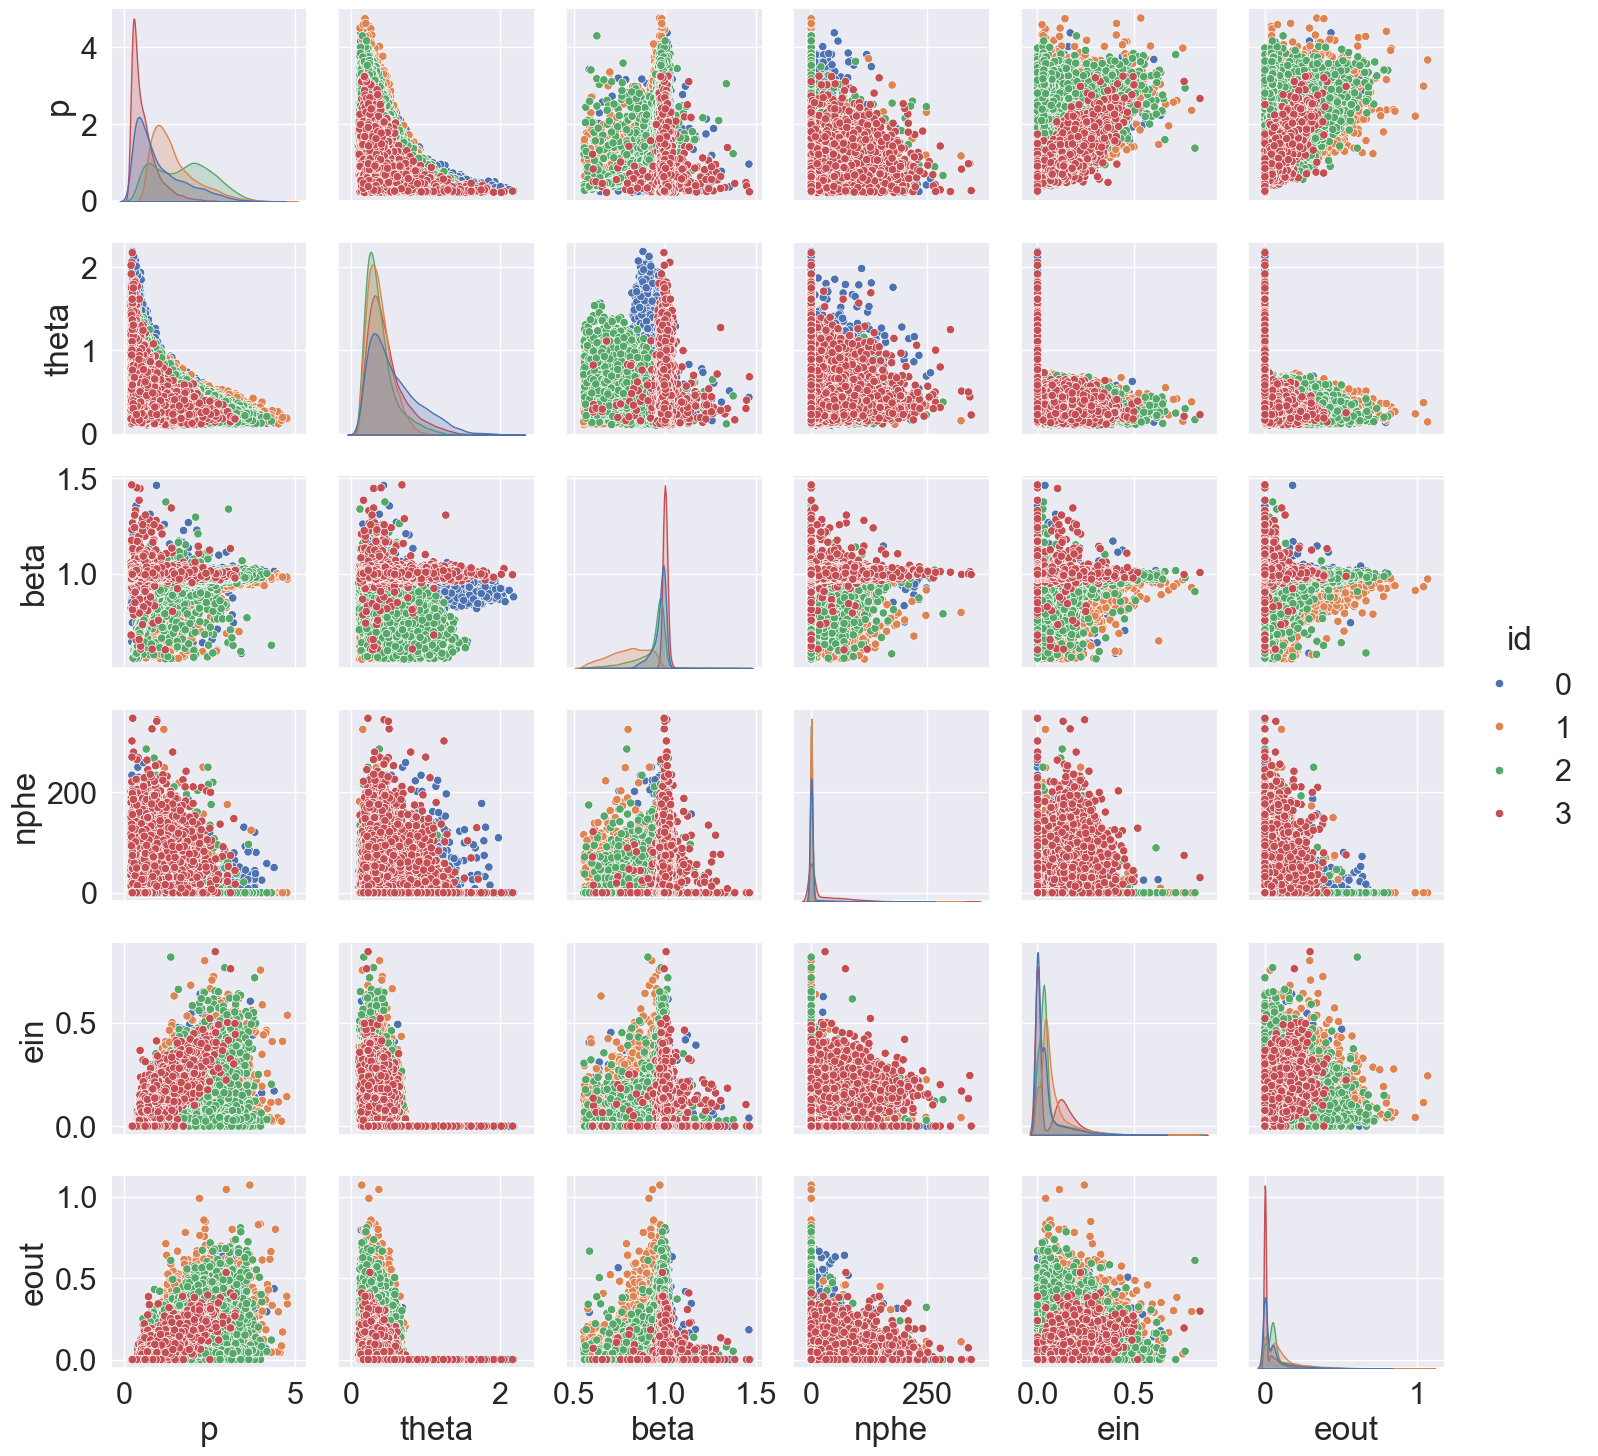

In [27]:
sns.set_theme(font_scale=2.0)
sns.pairplot(data=PID,hue='id',palette="deep");

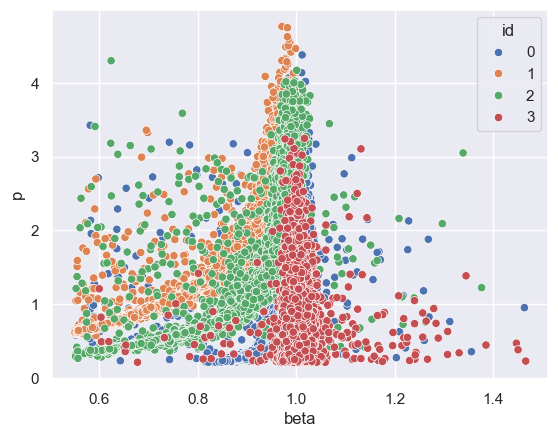

In [28]:
sns.set_theme(font_scale=1.0)
sns.scatterplot(data=PID,x="beta",y='p',hue='id',palette='deep');

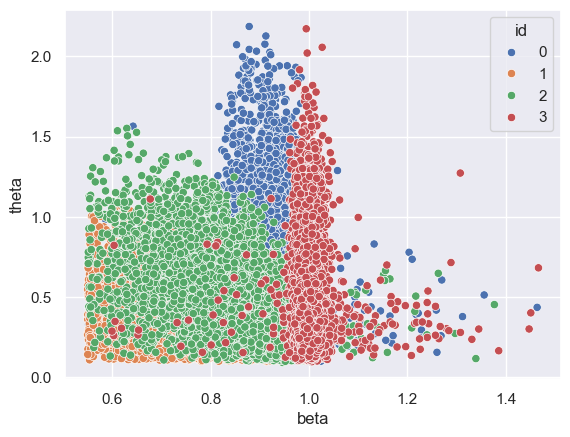

In [29]:
sns.set_theme(font_scale=1.0)
sns.scatterplot(data=PID,y="theta",x='beta',hue='id',palette='deep');

<h2 style='font-size:30px'> Visible Trends </h2><a id="trends1"></a>

&emsp;There is some serious overlap between many of these different particles. It may make sense to use some different tools to increase the variance or perform dimension reduction. Although we can clearly see that there are some well defined identifying trends, like the clear separation we can see in $Beta$ and $P$. Some of the different particle types like positrons and protons, which have clearly defined peaks. We can also see that there is a clear separation in $ein$ and $eout$, with kaons and protons having clearly defined energy peaks.

<h2 style='font-size:30px'> Out of The Box Performance </h2><a id="oobp"></a>

Accuracy: 89.56200000000001%


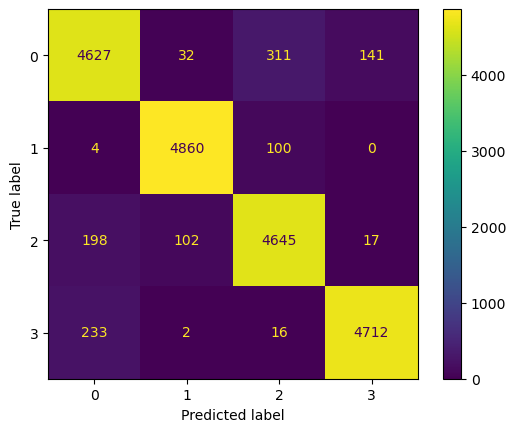

In [5]:
algo = RandomForestClassifier() # Testing out of the box performance

print(f"Accuracy: {100*cross_val_score(algo,X,y,cv=KFold(n_splits=5)).mean()}%")

algo.fit(X_train,y_train)
pred = algo.predict(X_test)

cm = confusion_matrix(y_test, pred, labels=algo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=algo.classes_)
disp.plot();

Accuracy: 87.162%


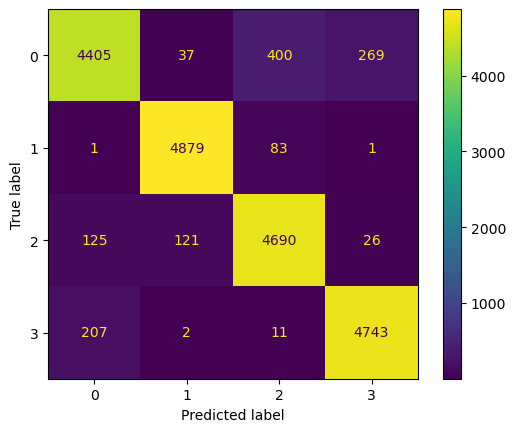

In [6]:
algo = MLPClassifier() # Testing out of the box performance

print(f"Accuracy: {100*cross_val_score(algo,X,y,cv=KFold(n_splits=5)).mean()}%")

algo.fit(X_train,y_train)
pred = algo.predict(X_test)

cm = confusion_matrix(y_test, pred, labels=algo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=algo.classes_)
disp.plot();

<h2 style='font-size:30px'> How Can We Improve The Models? </h2><a id="particle_improv1"></a>

&emsp;Random Forest has very good out of the box performance as can be seen here. A 90% accuracy rate with no parameter tuning is fantastic. However It looks like we'll need to do some work on our Neural Network here. Lets see how much more performance we can get out of both of them. I will start by performing a grid search for both to see what parameters are best.

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best Parameters:
  {'max_depth': 13, 'max_features': 35, 'n_estimators': 45}
Accuracy:
  93.93%


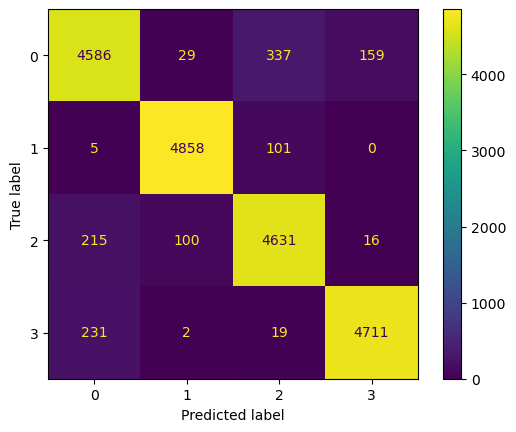

In [7]:
param_grid = {
    'max_features' : np.arange(35,55,5),
    'n_estimators' : np.arange(40,60,5),
    'max_depth' : np.arange(1,15,2),
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train,y_train)

pred = grid.predict(X_test)

print(f"Best Parameters:\n  {grid.best_params_}\nAccuracy:\n  {np.mean(pred==y_test)*100}%")

cm = confusion_matrix(y_test, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best Parameters:
  {'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 5000}
Accuracy:
  93.64%


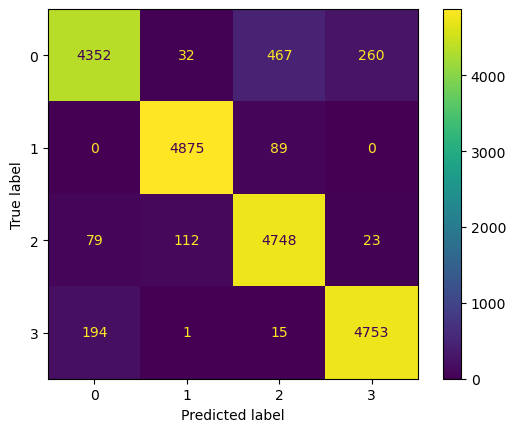

In [8]:
param_grid = {
    'hidden_layer_sizes':[(200,),(300,),(100,)],
    'activation':['logistic','tanh','relu'],
    'max_iter':[5000]
}

grid = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=2),
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train,y_train)

pred = grid.predict(X_test)

print(f"Best Parameters:\n  {grid.best_params_}\nAccuracy:\n  {np.mean(pred==y_test)*100}%")

cm = confusion_matrix(y_test, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

<h2 style='font-size:30px'> Can We Go Further? </h2><a id="particle_improv2"></a>

&emsp;Parameter tuning increased the accuracy of both of the classifiers. The neural network saw the biggest increase in accuracy, increasing from 87.16% to 93.64%, while the Random Forest increased from 89.5% to 93.93%. This is quite a good increase in performance, however we may be able to get more out of both, as I noted earlier, many of the different features in the data overlap, so something like dimension reduction using PCA may increase the variance of the different groups and increase the model accuracy too.

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best Parameters:
  {'max_depth': 11, 'max_features': 40, 'n_estimators': 55}
Accuracy:
  91.88499999999999%


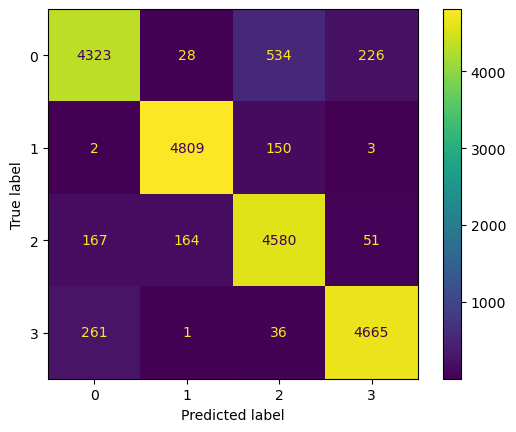

In [9]:
pca = PCA(n_components=4).fit(X) # 4 Dimensions seems to maximize the variance
X_test_pca = pca.transform(X_test)
X_train_pca = pca.transform(X_train)

algo = RandomForestClassifier()

param_grid = {
    'max_features' : np.arange(35,55,5),
    'n_estimators' : np.arange(40,60,5),
    'max_depth' : np.arange(1,15,2),
}

grid = GridSearchCV(
    estimator=algo,
    param_grid=param_grid,
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train_pca,y_train)

pred = grid.predict(X_test_pca)

print(f"Best Parameters:\n  {grid.best_params_}\nAccuracy:\n  {np.mean(pred==y_test)*100}%")

cm = confusion_matrix(y_test, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best Parameters:
  {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'max_iter': 5000}
Accuracy:
  91.8%


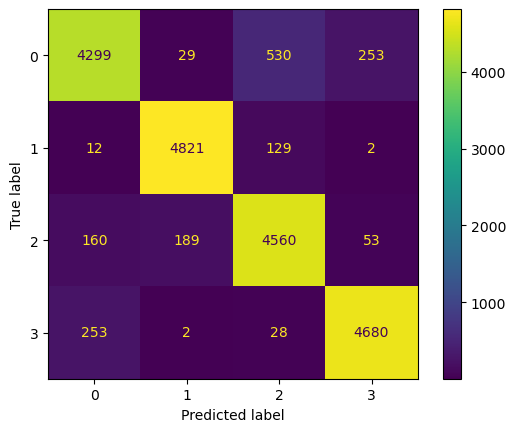

In [10]:
pca = PCA(n_components=4).fit(X) # Dimension reduction
X_test_pca = pca.transform(X_test)
X_train_pca = pca.transform(X_train)

param_grid = {
    'hidden_layer_sizes':[(200,),(300,),(100,)],
    'activation':['logistic','tanh','relu'],
    'max_iter':[5000]
}

grid = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=2),
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train_pca,y_train)

pred = grid.predict(X_test_pca)

print(f"Best Parameters:\n  {grid.best_params_}\nAccuracy:\n  {np.mean(pred==y_test)*100}%")

cm = confusion_matrix(y_test, pred, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid.classes_)
disp.plot();

<h2 style='font-size:30px'> Final Classification Results </h2><a id="particle_results"></a>

&emsp;Ultimately PCA was unable to increase the performance of each model, decreasing the performance by a few percent for each of them. The random forest dropped from 93.93% down to 91.88%, and the neural network dropped from 93.64% to 91.8%. I am unsure as to why this is the case, but the difference between the two is negligible at best. Even though the difference between both models performance wise is not noticeable, the random forest offers many, many benefits over the neural network. It is far quicker to train than the Neural network, taking slightly more time to perform >500 fits than the Neural network took to fit 18. Additionally the Random Forest showed increased accuracy in all of the tests, consistently edging out the neural network. Because of these results I believe that the random forest is the best model to use here.  

<h2 style='font-size:40px'> Binding Energy </h2><a id="BindingE"></a>

&emsp;Ideally I would like to make a model that can take the number of protons, neutrons, nucleon number, difference between number of neutrons and protons, and mass excess and predict what the binding energy will be. Binding energy is very important in Nuclear Physics and determines the behavior of all kinds of nuclear reactions. Knowing what the binding energy of an isotope is greatly impacts its properties, like whether it is radioactive or not. To be able to estimate this value without observing the actual isotope gives physicists a ballpark answer for what they might expect to see. This may be useful in predicting the binding energy for an isotope that has not been observed yet in a lab, maybe it does not naturally occur, there are many use cases for this. This will likely be useful for interpolation because we do not know if our models will hold up for heavier and heavier elements. 

<h2 style='font-size:30px'> Read In Data </h2><a id="read2"></a>
&emsp;Let's start by looking at the data and seeing what we have to work with here.

In [2]:
AtomicMass = pd.read_csv("atomicMassData.csv")

AtomicMass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   1nz         2498 non-null   int64  
 1   N           2498 non-null   int64  
 2   Z           2498 non-null   int64  
 3   A           2498 non-null   int64  
 4   EL          2498 non-null   object 
 5   MASSEXCESS  2498 non-null   float64
 6   AtomicMass  2498 non-null   float64
 7   BE          2498 non-null   float64
 8   BE_uncer    2498 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 175.8+ KB


In [3]:
AtomicMass.head()

,1nz,N,Z,A,EL,MASSEXCESS,AtomicMass,BE,BE_uncer
0,-1,0,1,1,H,7288.97061,1.007825,7680.144,7680.144
1,1,1,0,1,n,8071.31713,1.008665,7073.915,0.000
2,0,1,1,2,H,13135.72176,2.014102,0.000,0.000
3,-1,1,2,3,He,14931.21793,3.016029,1112.283,0.000
4,1,2,1,3,H,14949.80993,3.016049,7976.206,0.000


In [4]:
AtomicMass['Z'].unique() # 99 is too small to be the max value, there is a problem here

array([ 1,  0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 97, 99],
      dtype=int64)

In [5]:
AtomicMass['EL'].unique()

array(['H ', ' n', 'He', 'Li', 'Be', 'B ', 'C ', 'N ', 'O ', 'F ', 'Ne',
       'Na', 'Mg', 'Al', 'Si', 'P ', 'S ', 'Cl', 'Ar', 'K ', 'Ca', 'Sc',
       'Ti', 'V ', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge',
       'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y ', 'Zr', 'Nb', 'Mo', 'Tc',
       'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I ', 'Xe',
       'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb',
       'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W ', 'Re', 'Os',
       'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr',
       'Ra', 'Ac', 'Th', 'Pa', 'U ', 'Np', 'Pu', 'Am', 'Cm', 'Cf', 'Bk',
       'Fm', 'Es', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Hs', 'Ds'],
      dtype=object)

<h2 style='font-size:30px'> Data Cleaning </h2><a id="clean2"></a>

&emsp;It seems that we will need to do some data cleaning here. We have no NaN values so that is good, but the proton number should go higher than 99. It seems that the dataset has an error where the proton number reaches 99, then restarts from zero again. We can fix this quite easily, as the Neutron and Nucleon numbers are correct, so we can just replace the Proton number with the difference of the two. We can also see that there is a column with the names of the elements, this will need to be dealt with. We can either turn this column into $\approx$ 100 dummy variables or ignore it altogether. I think it makes more sense to drop is as it is not a numeric value, and a name should not have an effect on the predicted binding energy. Additionally, I believe that It makes sense to drop the uncertainty in the binding energy, as we will not have this when predicting the value for any isotope.

In [6]:
AtomicMass['Z'] = AtomicMass['A'] - AtomicMass['N'] # The number of protons was wrong, so I'm fixing it here Z = A - N

X = AtomicMass.drop(["BE","BE_uncer","EL","MASSEXCESS"],axis=1)
y = AtomicMass["BE"]

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.4 , random_state=1)

<h2 style='font-size:30px'> First Look </h2><a id="First_Look2"></a>

&emsp;For this set $n=2498$ and $p=5$. Lets get an idea for how well our models are able to predict on this data. Our 5 predictors are $1nz$ which is the difference between the number of neutrons and protons, $N$ which is the number of neutrons, $Z$ which is the number of protons, $A$ which is the sum of the protons and neutrons, and AtomicMass which is the actual mass of the isotope. It is important to note that Atomic Mass is not just the sum of the protons and neutrons, it is affected by the binding energy and is always less than $A$. Our response variable is the binding energy per nucleon in MeV/U, called $BE$ in the dataframe.

&emsp;Let's start by getting an idea of what the relationships in the data look like. I will start by making some data visualizations to see if our models will be able to capitalize on trends in the data.

(2498, 5)

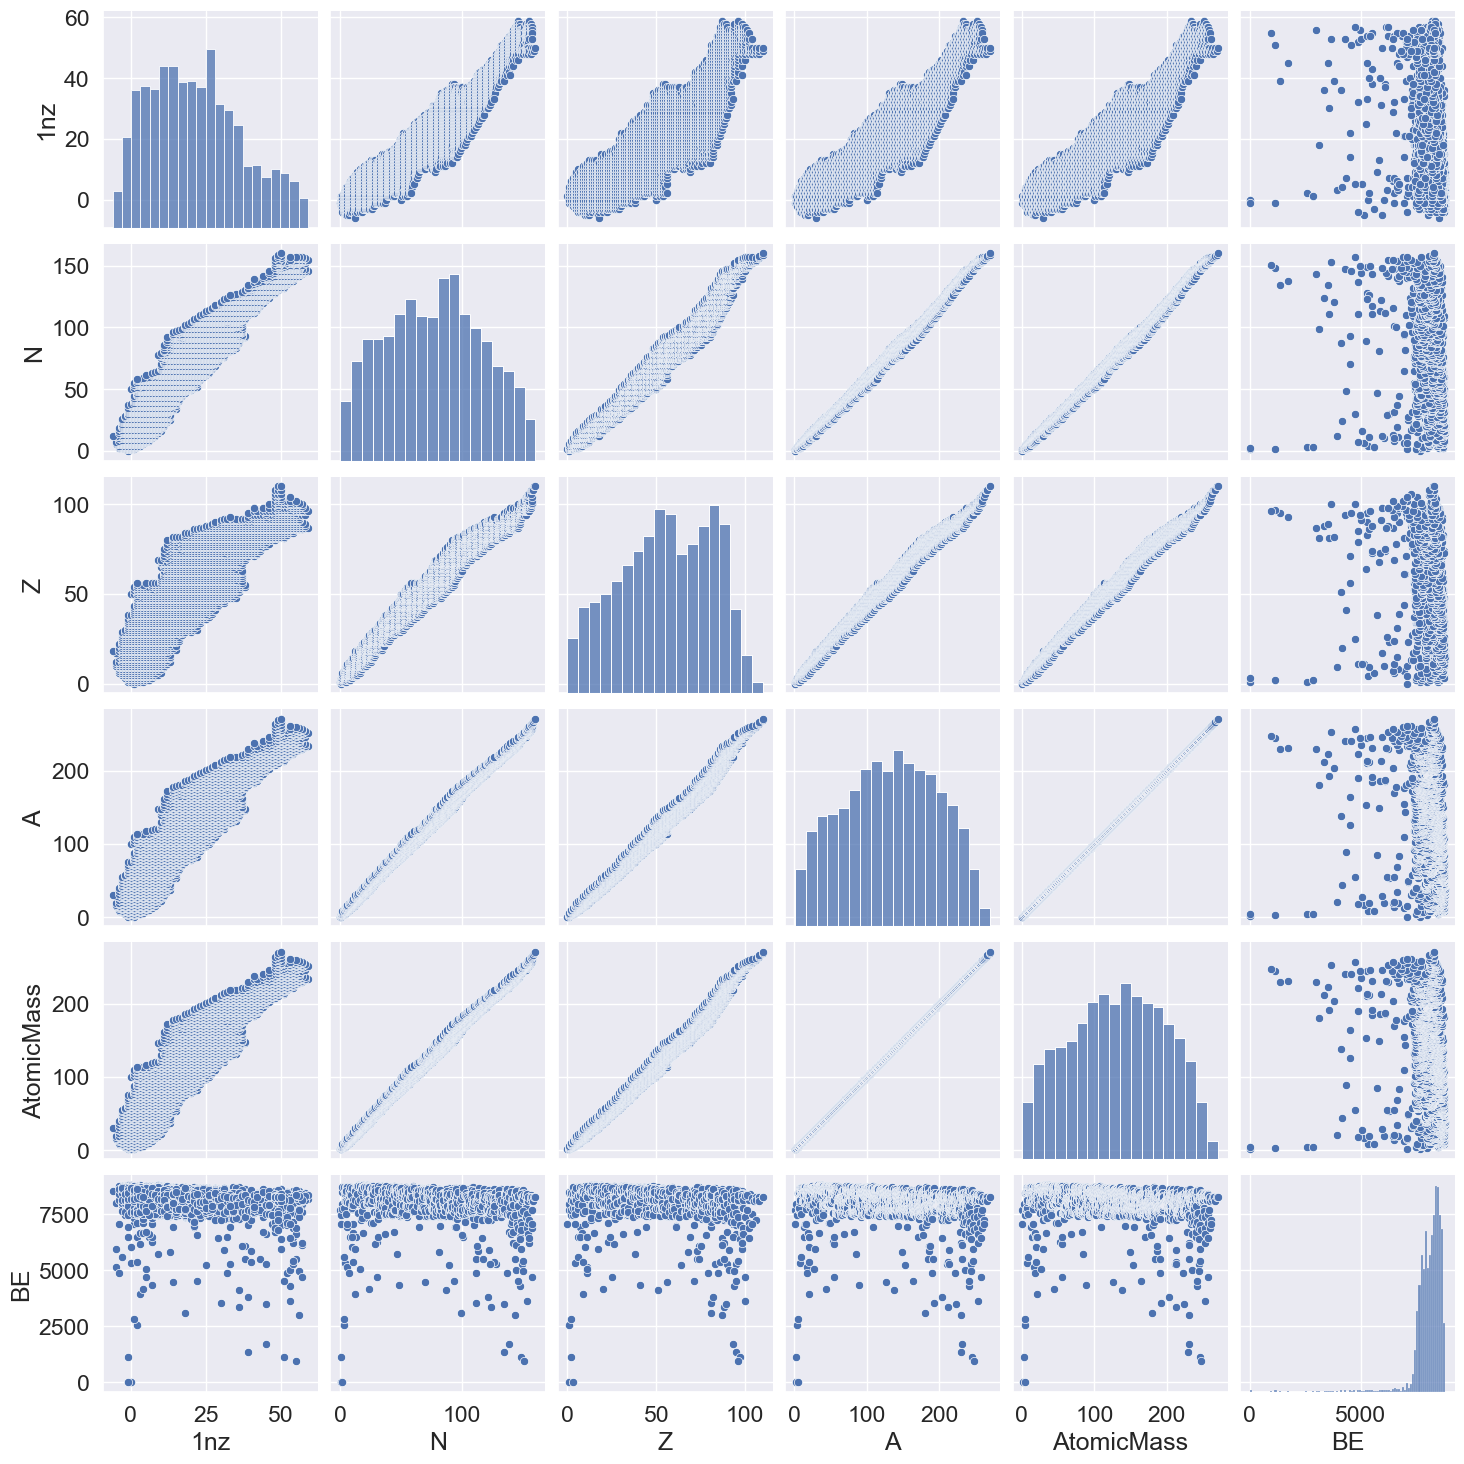

In [23]:
sns.set_theme(font_scale=1.5)
sns.pairplot(data=AtomicMass.drop(["BE_uncer","EL",'MASSEXCESS'],axis=1));
X.shape # Making sure that the number of predictors is correct

<h2 style='font-size:30px'> Visible Trends </h2><a id="trends2"></a>

&emsp;Looking at the data we can clearly see that there are strong correlations between $Z$, $A$, AtomicMass, and $N$. This makes total sense because they are directly proportional to each other. Meanwhile the trend for Binding Energy with all of the others is roughly the same. A flat line around 7600 with a high variance around it, and with some drop-offs at the far extrema. Because these relationships are similar and nonlinear it makes sense to try using linear models like LASSO to reduce the importance of some predictors or Polynomial Regression or Neural Network regression to meet the nonlinear nature of the relationships. I will start by testing LASSO.

<h2 style='font-size:30px'> LASSO </h2><a id="lasso"></a>

&emsp; LASSO generally performs better than linear regression and is quite easy to tune, we only need to vary $\alpha$. I will use KFold cross validation to ensure that we don't just find the best parameters for the testing and training data, we want to find the $\alpha$ that minimizes the mean MSE for all of the data. I will also employ StandardScaler to make sure that the mean is zero and the variance is 1, so that the coefficients represent their importance.

In [36]:
MODEL = make_pipeline(StandardScaler(), Lasso())
MSE = -1*cross_val_score(MODEL,X, y, cv=KFold(n_splits=5), scoring='neg_mean_squared_error').mean()
print(f"LASSO MSE:",MSE)

LASSO MSE: 539522.3561402927


&emsp;The out of box performance for LASSO is not very impressive, this is a very large MSE. Lets see what $\alpha$ minimizes this.

Best MSE: 538622.3448160131
Alpha at min: 21.494746734379806


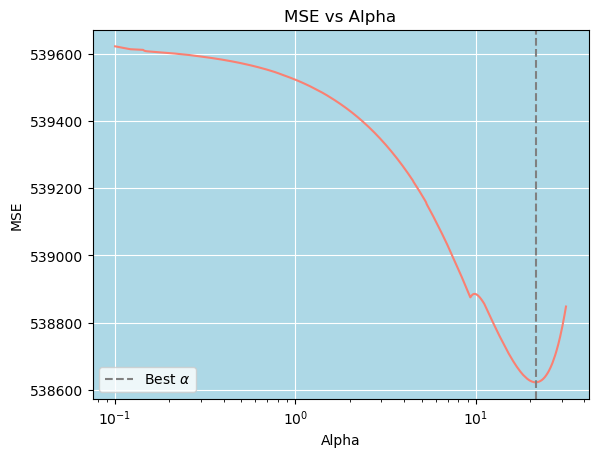

In [16]:
# Finding the ideal alpha for LASSO

alphas = 10**np.linspace(-1,1.5,1000)

errors = np.zeros(1000)

for i,a in enumerate(alphas):
    MODEL = make_pipeline(StandardScaler(), Lasso(alpha = a))
    errors[i] = -1*cross_val_score(MODEL,X, y, cv=KFold(n_splits=5), scoring='neg_mean_squared_error').mean() # use KFold to get better estimate for MSE

minidx = np.argmin(errors)
print("Best MSE:",errors[minidx])
print("Alpha at min:",alphas[minidx])

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.title("MSE vs Alpha")
plt.plot(alphas,errors,c='salmon');
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.axvline(x=alphas[minidx],label="Best $\\alpha$",linestyle="--",c="gray")
plt.legend()
plt.show()

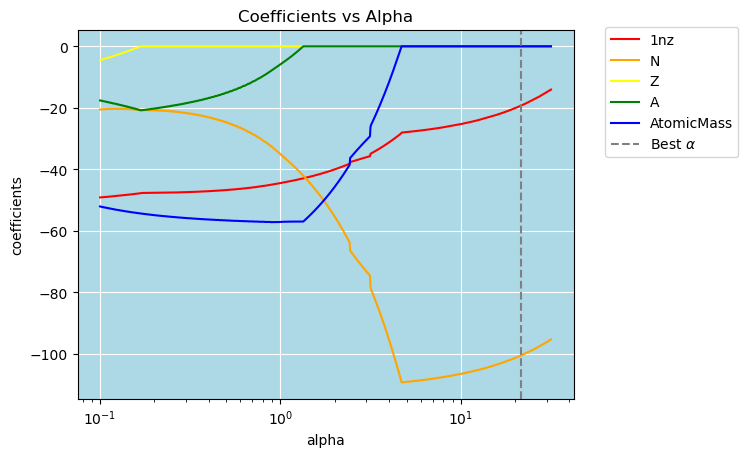

In [17]:
coefs = []

for a in alphas:
    model = make_pipeline(StandardScaler(), Lasso(alpha = a)).fit(X, y)
    coefs.append(model.named_steps['lasso'].coef_)
    
coefs = pd.DataFrame(coefs,columns = X.columns)

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
ax.set_prop_cycle(color=['red','orange','yellow','green','blue','purple'])
plt.grid(c='white')
plt.plot(alphas, coefs, label = coefs.columns)
plt.title("Coefficients vs Alpha")
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.axvline(x=alphas[minidx],linestyle='--',c='gray',label='Best $\\alpha$')
plt.legend(bbox_to_anchor = (1.05,1.025));
   

Test MSE: 498146.15786723985


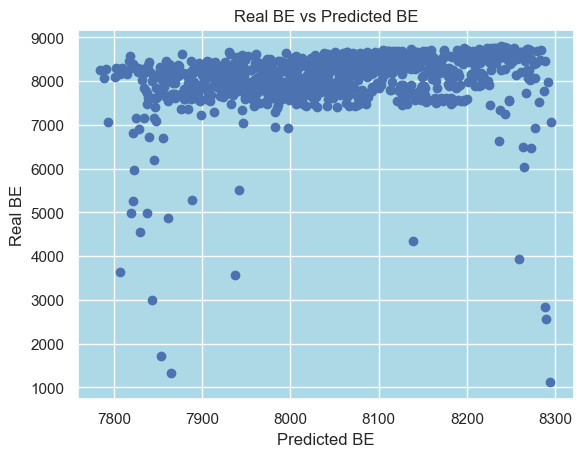

In [52]:
lasso = Lasso(alpha=alphas[minidx]).fit(X_train,y_train)

yhat = lasso.predict(X_test)

print(f"Test MSE: {mean_squared_error(yhat,y_test)}")
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.scatter(yhat,y_test)
plt.title("Real BE vs Predicted BE")
plt.xlabel("Predicted BE")
plt.ylabel("Real BE");

&emsp;In the figure above we ideally would like to see a $y=x$ line where the Predicted Binding Energy is nearly the same as the Real Binding Energy. I chose to use this kind of plot because it avoids having to pick some predictor to plot the output against, and directly compares the predicted value to the real value.

<h2 style='font-size:30px'> Results For LASSO </h2><a id="lasso_results"></a>

&emsp;LASSO saw a minimum MSE of around 538,000 at an $\alpha$ of 21.5. This is not a fantastic result, Ideally we would like to have a much lower MSE. The model learned roughly a straight line, which is also disappointing, with all of the predictors I had hoped that it would have been able to capture the variance much better. It is interesting to me that the atomic mass, proton number, and nucleon number all went to zero, as the binding energy should be related to these properties. I also find it interesting that the neutron number coefficient became much more important as $\alpha$ increased, and how the difference between the number of neutrons and protons never became zero. Neutrons are very important in the properties of nuclei, as they can greatly affect stability of isotopes, and that appears to be reflected here, as neutron number had the most importance in the model.


<h2 style='font-size:30px'> Polynomial Regression </h2><a id="poly"></a>

&emsp;Polynomial regression should be able to better reflect the nonlinear relations in the data, so we'll start with performing KFold on a few different degrees of polynomial fits. 

In [38]:
MODEL = make_pipeline(PolynomialFeatures(include_bias=False),LinearRegression())
MSE = -1*cross_val_score(MODEL,X,y,scoring="neg_mean_squared_error",cv=KFold(n_splits=10)).mean()
print(f"Polynomial MSE:",MSE)

Polynomial MSE: 537998.0770291518


&emsp;The out of box performance for polynomial regression is far from impressive. We should take a look at different polynomial degrees and see if there is one that minimizes this.

Best polynomial degree from kfold cv is: 1 
BEst MSE: 505583.41061938787


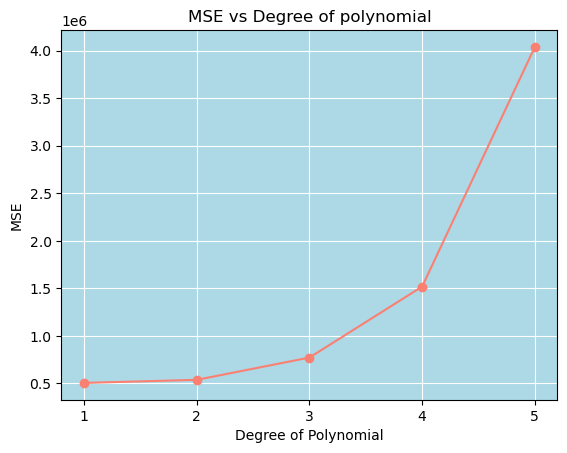

In [19]:
degs = list(range(1,6))
errors = []

# Loop over a range of degrees and find the best MSE using KFold
for i in degs:
    polyfit = make_pipeline(PolynomialFeatures(degree=i,include_bias=False),LinearRegression())
    errors.append(-1*cross_val_score(polyfit,X,y,scoring="neg_mean_squared_error",cv=KFold(n_splits=10)).mean())

bestdegree = np.argmin(errors)+1
print("Best polynomial degree from kfold cv is:",bestdegree,"\nBEst MSE:",errors[bestdegree-1])

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.title("MSE vs Degree of polynomial")
plt.xlabel('Degree of Polynomial')
plt.ylabel('MSE')
plt.xticks(degs)
plt.plot(degs,errors,c='salmon')
plt.scatter(degs,errors,c='salmon');

Test MSE: 487445.67102200125


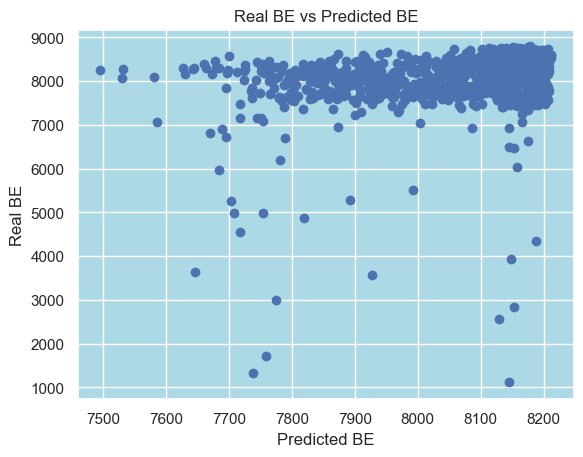

In [58]:
polyfit = make_pipeline(PolynomialFeatures(degree=bestdegree,include_bias=False),LinearRegression())
polyfit.fit(X_train,y_train)
yhat = polyfit.predict(X_test)

# The x axis was chosen to be N because it had the strongest relation in the LASSO model
print(f"Test MSE: {mean_squared_error(yhat,y_test)}")
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.scatter(yhat,y_test)
plt.title("Real BE vs Predicted BE")
plt.xlabel("Predicted BE")
plt.ylabel("Real BE");

<h2 style='font-size:30px'> Polynomial Regression Results </h2><a id="poly_results"></a>

&emsp;Polynomial regression performed quite a bit better than LASSO, the MSE dropped from 538,000 to 505,000. This MSE is still somewhat disappointing and clearly shows that another method will need to be used here to better capture the variance in the data. Ironically once again the model learned a 1st degree fit, meaning that this is just a linear regression with interaction terms between the different predictors. Clearly the model was able to capture more of the variance, as the predicted values are distributed less uniformly, and are grouping up towards the top right, which is closer to where they should actually be. It is still clearly unable to pick up on the relationship between the data and nuclei with low binding energies here.

<h2 style='font-size:30px'> Neural Network Regressor </h2><a id="nn"></a>

&emsp;Polynomial Regression and LASSO failed to capture the variance in the data, as a last resort I have decided to try using a Neural Network. Neural networks don't rely on parameters like linear and polynomial regressions do, and as such may fit better to the nonlinear nature of the data. Let's see how it performs.

MSE: 13308779.713585086


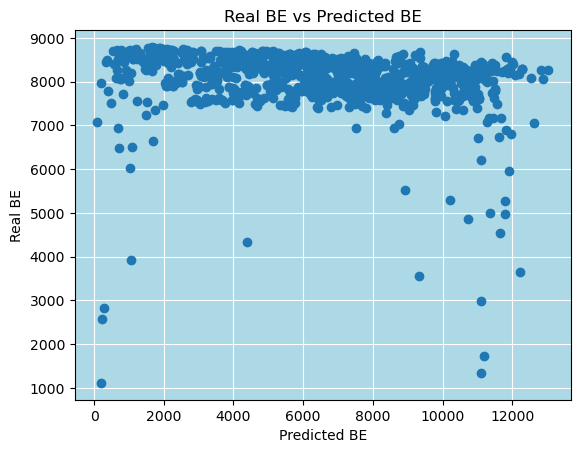

In [7]:
# Just testing the out of the box performance of the MLP Regressor, clearly we need to do some parameter tuning

algo = MLPRegressor()
algo.fit(X_train,y_train)

yhat=algo.predict(X_test)

print(f"MSE: {mean_squared_error(yhat,y_test)}")
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.scatter(yhat,y_test)
plt.title("Real BE vs Predicted BE")
plt.xlabel("Predicted BE")
plt.ylabel("Real BE");

&emsp;From the image above it is very clear that parameter tuning is needed for this to better capture the data, the network doesn't appear to have picked up on any trends in the data. The optimizer clearly failed to find the best weights to capture the variance. One big change that clearly needs to be made is to increase the number of iterations that the optimizer is allowed to perform.

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Params:
  {'activation': 'logistic', 'hidden_layer_sizes': (300,), 'max_iter': 5000, 'solver': 'lbfgs'}
Best MSE:
  514873.9487369787
Test MSE: 456101.63303288363


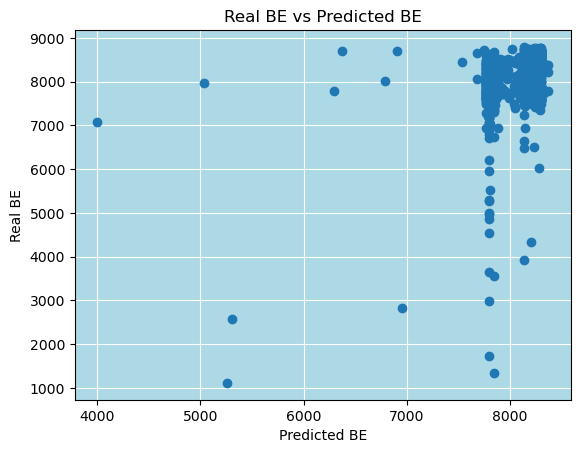

In [8]:
# Parameter tuning the model to get better results

param_grid = {
    'hidden_layer_sizes':[(200,),(300,),(400,)],
    'activation':['logistic','tanh','relu'],
    'max_iter':[5000],
    'solver':['lbfgs']
}

grid = GridSearchCV(
    param_grid=param_grid,
    estimator=MLPRegressor(),
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train,y_train)

yhat=grid.predict(X_test)

print(f"Best Params:\n  {grid.best_params_}\nBest MSE:\n  {grid.best_score_*-1}")
print(f"Test MSE: {mean_squared_error(yhat,y_test)}")
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
plt.grid(c='white')
plt.scatter(yhat,y_test)
plt.title("Real BE vs Predicted BE")
plt.xlabel("Predicted BE")
plt.ylabel("Real BE");

<h2 style='font-size:30px'> Neural Network Regression Results </h2><a id="nn_results"></a>

&emsp;The Neural Network performed right between the other two models. The best was the polynomial regression with an MSE of 505,000, the neural net lags behind with an MSE of 514,000. The Neural Network's ability to fit to nonlinear data is apparent here, as we can see that the outputs are somewhat well grouped here with the real binding energy amd predicted binding energy being clustered in the top right. Everywhere outside of the top right we can see that the Neural Network failed to identify some property that would have affected the binding energy, which is disappointing. The biggest downside of using a neural network like this is that the final model is not deterministic like the other parametric models like LASSO or Polynomial regression. This means that there is large variance in the model. 

<h2 style='font-size:30px'> Final Regression Results </h2><a id="regression_results"></a>

&emsp;This dataset is highly nonlinear and very few of the predictors have any strong relationship with the response. This is clearly apparent with such large values for all of the different MSE values. None of these models were able to do much more than find a trend-line that runs through the middle of the dataset at all points, and this is very disappointing. The KFold MSE values differed pretty significantly from the test MSE for all of the models, with the test MSE being lower for all of the models. This is very interesting, with the Neural Network by far having the lowest test MSE. However it is unclear to me whether this is a product of chance or not, and as such I will only consider the KFold MSE. Out of these models, the Polynomial Regression has many advantages over all of the other models, it trains quickly as it just uses a least squares approach to this. LASSO trains quickly but does not achieve the same level of accuracy as the polynomial regression, and was still beaten out by the neural network. The neural network has higher accuracy than the LASSO fit, but requires much longer to fit to the data, and in many preliminary tests failed to find a fit to the data at all. For all of these reasons I believe that Polynomial Regression is the best choice for this dataset.


<h2 style='font-size:40px'> Discussion </h2><a id="discussion"></a>

<h2 style='font-size:30px'> Classification Discussion </h2><a id="class_disc"></a>

&emsp;Both classifiers performed at the same level of accuracy, however the Random Forest classifier was faster to train and had marginally better performance. While 94% accuracy is great, there is some debate in the physics community as to whether machine learning should be applied to solving such issues, as deterministic algorithms may be better if the prediction model is well designed and have less randomness in prediction. There is also the added layer of all of the classification data coming from a simulation. Simulations cannot account for certain things, until the actual detector is built and tested there is no way to know if the various detector parts like the scintillator material will perform the same way it does in the simulation, if the beam coming into the detector is a perfect mix of the particles of interest, and many more sources of error. Training a machine learning model on simulated data could cause error to compound, as it is not being trained on real data. So if anything my classification models are only a proof of concept and likely would produce much worse results with real data than with simulated data.

&emsp;Going forward it would be interesting to apply these same models to real detector data. That is the clear next step, and would serve to show that machine learning models can be applied to real data without introducing too much error or randomness. This would also serve to save time for scientists, who will have to spend less time creating and refining deterministic models.

<h2 style='font-size:30px'> Regression Discussion </h2><a id="reg_disc"></a>

&emsp;All three regression models had disappointing results. As with the discussion around the use of machine learning models for classification in detector data, the same applies to data like this. These results show that sometimes, if not often, machine learning models cannot capture trends in the data and a better more theoretical model is needed. This is the kind of problem that requires a theoretical model to solve. Currently in the world of nuclear and particle physics, the shell model serves to describe the behavior and structure of nuclei, and likely there is some way to use that model to more accurately predict the binding energy from the $Z$, $A$, $N$, and Atomic mass.

&emsp;Going forward if more research is to be put into this topic, an intimate mixture of theory and machine learning should be combined to produce the best results. Clearly as is shown here, machine learning alone is not enough to find an adequate solution. 

<h2 style='font-size:40px'> References </h2><a id="references"></a>

<ol>
<li>NuclearReaction. (n.d.). In Wikimedia Commons. Retrieved November 19, 2024, from https://commons.wikimedia.org/wiki/File:NuclearReaction.svg</li>

<li>How can I add a table of contents to a Jupyter / JupyterLab notebook? (n.d.). Stack Overflow. https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-a-jupyter-jupyterlab-notebook</li>
</ol>